In [1]:
import pandas as pd
import numpy as np
import os

import cv2
from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
os.chdir("/kaggle/input/petfinder-pawpularity-score/")

train = pd.read_csv(os.path.join(os.getcwd(),"train.csv"))
test = pd.read_csv(os.path.join(os.getcwd(),"test.csv"))
print(train.shape, test.shape)

train_images_path = (os.path.join(os.getcwd(),"train"))
test_images_path = (os.path.join(os.getcwd(),"test"))

train_images_list = os.listdir(train_images_path)
test_images_list = os.listdir(test_images_path)
train_label = train['Pawpularity']

print(len(train_images_list),len(test_images_list), train_label.shape)

(9912, 14) (8, 13)
9912 8 (9912,)


In [3]:
image_dim = (128, 128, 3)

# Train images
train_images = []
for image_id in tqdm(train_images_list):
    path = os.path.join(train_images_path, image_id)
    image = cv2.imread(path)
    image = image / 255
    image = cv2.resize(image, (64,64), interpolation=cv2.INTER_AREA) # INTER.AREA best when shrinking images
    train_images.append(image)
train_images = np.array(train_images)  
print(train_images.shape)

100%|██████████| 9912/9912 [03:55<00:00, 42.18it/s]


(9912, 64, 64, 3)


In [4]:
# Test images
test_images = []
for image_id in tqdm(test_images_list):
    path = os.path.join(test_images_path, image_id)
    image = cv2.imread(path)
    image = image / 255
    image = cv2.resize(image, (64,64), interpolation=cv2.INTER_AREA)
    test_images.append(image)
test_images = np.array(test_images)  
print(test_images.shape)

100%|██████████| 8/8 [00:00<00:00, 106.78it/s]

(8, 64, 64, 3)


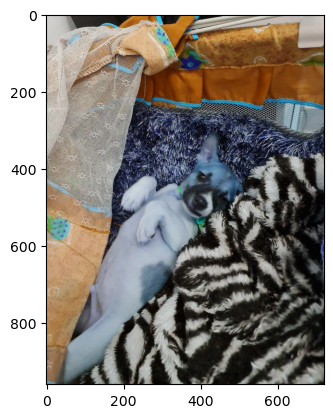

In [5]:
plt.imshow(cv2.imread(os.path.join(train_images_path, train_images_list[0])))

In [6]:
train_labels = train.drop(['Id'], axis=1)

In [7]:
#generate train - validation splits  90% train - 10% validation
x_train, x_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.1, random_state=7)

In [8]:
cnn_model_in = keras.Input(shape=(64, 64, 3))
x = layers.Conv2D(32, (3, 3), activation='relu')(cnn_model_in)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
cnn_model_out = layers.Dense(1)(x)

model = keras.Model(inputs=cnn_model_in, outputs=cnn_model_out, name='cnn_model')

model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                     

In [9]:
learning_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
initial_learning_rate = 0.002,
decay_steps = 10000,
decay_rate = 0.99)

opt = tf.keras.optimizers.Adam(learning_rate = learning_schedule)

model.compile(optimizer=opt, loss='mse', metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [10]:
data_augmentation = ImageDataGenerator(
    rotation_range = 15, 
    width_shift_range = 0.2, 
    height_shift_range = 0.2,
    brightness_range=(0.1, 0.9),
    shear_range = 0.1,
    zoom_range = 0.15,
    horizontal_flip = True, 
    fill_mode = "nearest")

In [11]:
keras_callbacks   = [
      tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1),
      tf.keras.callbacks.ModelCheckpoint('/kaggle/working/best_cnn_model_so_far.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
]

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

model.fit(
    data_augmentation.flow(x_train, y_train, batch_size=32),
    validation_data=(x_val, y_val),
    epochs=60, verbose=1, shuffle=True,
    callbacks=[keras_callbacks])

Epoch 1/60
279/279 [==============================] - ETA: 0s - loss: 142.5109 - rmse: 11.9378
Epoch 1: val_loss improved from inf to 140.93344, saving model to /kaggle/working/best_cnn_model_so_far.h5
279/279 [==============================] - 37s 130ms/step - loss: 142.5109 - rmse: 11.9378 - val_loss: 140.9334 - val_rmse: 11.8715
Epoch 2/60
279/279 [==============================] - ETA: 0s - loss: 139.8040 - rmse: 11.8239
Epoch 2: val_loss improved from 140.93344 to 138.72057, saving model to /kaggle/working/best_cnn_model_so_far.h5
279/279 [==============================] - 36s 130ms/step - loss: 139.8040 - rmse: 11.8239 - val_loss: 138.7206 - val_rmse: 11.7780
Epoch 3/60
279/279 [==============================] - ETA: 0s - loss: 137.7986 - rmse: 11.7388
Epoch 3: val_loss improved from 138.72057 to 137.12836, saving model to /kaggle/working/best_cnn_model_so_far.h5
279/279 [==============================] - 36s 131ms/step - loss: 137.7986 - rmse: 11.7388 - val_loss: 137.1284 - val_

In [12]:
#predict on the submission data
cnn_pred = model.predict(test_images)
print(test_images.shape, type(test_images))
print(cnn_pred.shape, type(cnn_pred))

1/1 [==============================] - 0s 114ms/step
(8, 64, 64, 3) <class 'numpy.ndarray'>
(8, 1) <class 'numpy.ndarray'>


In [13]:
#put the submission predictions alongside their associated Ids
cnn = pd.DataFrame()
cnn['Id'] = test['Id']
cnn['Pawpularity'] = cnn_pred #[:,-1]
cnn.to_csv('/kaggle/working/submission.csv',index=False)